# Sentiment-based product recommendation system

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings. 

 In order to do this, we planned to build a sentiment-based product recommendation system, which includes the following tasks.

-Data sourcing and sentiment analysis
- Building a recommendation system
- Improving the recommendations using the sentiment analysis model
- Deploying the end-to-end project with a user interface

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import Libraries

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

#Visualisation
import seaborn as sns             
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
!ls "/content/gdrive/MyDrive/Datasets"

CNN_assignment	Iris.csv      Project_data  telecom_churn_data.csv
digit		mnist.pkl.gz  sample30.csv  xgboost_gpu_randomsearch.csv


## Data Analysis and EDA

In [4]:
# Load the dataframe
recommend_df = pd.read_csv("/content/gdrive/MyDrive/Datasets/sample30.csv")
recommend_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [5]:
# Display the last set of 5 rows
recommend_df.tail()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
29995,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-23T00:00:00.000Z,False,True,5,I got this conditioner with Influenster to try...,Softness!!,NaN,NaN,laurasnchz,Positive
29996,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-27T00:00:00.000Z,False,True,5,"I love it , I received this for review purpose...",I love it,NaN,NaN,scarlepadilla,Positive
29997,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-21T00:00:00.000Z,False,True,5,First of all I love the smell of this product....,Hair is so smooth after use,NaN,NaN,liviasuexo,Positive
29998,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-11T00:00:00.000Z,False,True,5,I received this through Influenster and will n...,Perfect for my oily hair!,NaN,NaN,ktreed95,Positive
29999,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-19T00:00:00.000Z,False,True,5,I received this product complimentary from inf...,Conditioned into healthy,NaN,NaN,kcoopxoxo,Positive


In [6]:
# Get all the number of null values for each column
recommend_df.isna().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [7]:
# Get the overall information about the dataset
recommend_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [8]:
# Get the percentage of null values for each column
(recommend_df.isna().sum() / recommend_df.shape[0] * 100).round(2)

id                       0.00
brand                    0.00
categories               0.00
manufacturer             0.47
name                     0.00
reviews_date             0.15
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_rating           0.00
reviews_text             0.00
reviews_title            0.63
reviews_userCity        93.57
reviews_userProvince    99.43
reviews_username         0.21
user_sentiment           0.00
dtype: float64

In [9]:
# Removing the reviews_userProvince and reviews_userCity columns as it contains more than 90% of values as null
recommend_df.drop(columns=['reviews_userProvince', 'reviews_userCity'], axis=1, inplace=True)

In [10]:
# Filter out the reviews_username column to contain all non null values
recommend_df = recommend_df[recommend_df['reviews_username'].notna()]

In [11]:
# Filter out the user_sentiment column to contain all non null values
recommend_df = recommend_df[recommend_df['user_sentiment'].notna()]

In [12]:
recommend_df.shape

(29936, 13)

In [13]:
# Fill out the null columns in reviews_title with empty string as we will concatenate the reviews_text later
recommend_df['reviews_title']=  recommend_df['reviews_title'].fillna(' ')

In [14]:
# Filling out the columns with necessary values to replace null values
recommend_df['reviews_didPurchase'].fillna(False , inplace=True)
recommend_df['reviews_doRecommend'].fillna(False , inplace=True)
recommend_df['manufacturer'].fillna('Unknown manufacturer', inplace=True)

In [15]:
# Removing duplicates entries based on the id, user name and date.
# Finding a similar entry across these three subsets means a duplicate entry
recommend_df.drop_duplicates(subset=['id', 'reviews_username', 'reviews_date'] , keep='first', inplace=True)

In [16]:
# Dropping the date column as it won't be useful in recommendation system
recommend_df.drop(columns=['reviews_date'], axis=1, inplace=True)

In [17]:
# Confirm that all null values has been handled correctly
(recommend_df.isna().sum() / recommend_df.shape[0] * 100).round(2)

id                     0.0
brand                  0.0
categories             0.0
manufacturer           0.0
name                   0.0
reviews_didPurchase    0.0
reviews_doRecommend    0.0
reviews_rating         0.0
reviews_text           0.0
reviews_title          0.0
reviews_username       0.0
user_sentiment         0.0
dtype: float64

In [18]:
recommend_df.shape

(29781, 12)

In [19]:
# Pickling the clean data for later usage
recommend_df.to_pickle('final_eda', compression='zip')

In [20]:
# Creating a unique pdt_name/id data frame for mapping in engine
map_products = recommend_df.drop_duplicates(subset='id',keep='first')[['id','name','categories']]

In [21]:
# Creating a master dataframe for the sentiment model creation
recommend_df_master = recommend_df[['id','reviews_username','name','reviews_rating','user_sentiment']].copy()

# Combining both reviews_title and reviews_text message as we need to find the sentiment from this column
recommend_df_master['reviews'] = recommend_df['reviews_title'] + " " + recommend_df['reviews_text']

In [22]:
recommend_df_master.head()

,id,reviews_username,name,reviews_rating,user_sentiment,reviews
0,AV13O1A8GV-KLJ3akUyj,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,Positive,Just Awesome i love this album. it's very good...
1,AV14LG0R-jtxr-f38QfS,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5,Positive,Good Good flavor. This review was collected as...
3,AV16khLE-jtxr-f38VFn,rebecca,K-Y Love Sensuality Pleasure Gel,1,Negative,Disappointed I read through the reviews on her...
4,AV16khLE-jtxr-f38VFn,walker557,K-Y Love Sensuality Pleasure Gel,1,Negative,Irritation My husband bought this gel for us. ...
5,AV16khLE-jtxr-f38VFn,samantha,K-Y Love Sensuality Pleasure Gel,1,Negative,Not worth it My boyfriend and I bought this to...


### Plot distibution for Rating

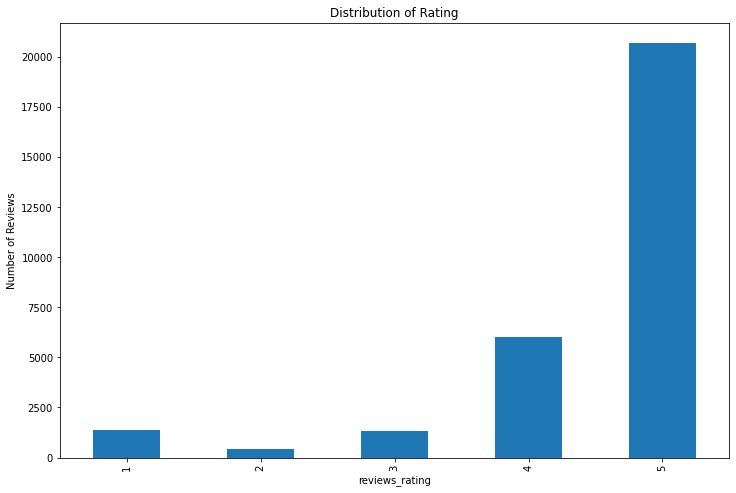

In [23]:
plt.figure(figsize=(12,8))
recommend_df_master['reviews_rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('reviews_rating')
plt.ylabel('Number of Reviews')
plt.show()

In [24]:
# Checking the user_sentiment column for analysing the trend
recommend_df_master['user_sentiment'].value_counts()

Positive    26439
Negative     3342
Name: user_sentiment, dtype: int64

In [25]:
# Statistics of non-numeric variables

# Number of unique customers
print('\nNumber of unique customers : {}'.format(len(recommend_df_master['reviews_username'].unique())))

# Review number per unique customer
print('\nReview per customer: {}'.format((len(recommend_df_master)/len(recommend_df_master['reviews_username'].unique()))))      



Number of unique customers : 24914

Review per customer: 1.1953520109175564


In [26]:
recommend_df_master['reviews_username'].value_counts().sort_values(ascending=False)[:5]

byamazon customer    41
mike                 36
chris                32
lisa                 16
sandy                15
Name: reviews_username, dtype: int64

In [27]:
# Converting the user_sentiment column to numerical column
# Postive => 1 Negative => 0
recommend_df_master['user_sentiment'] = recommend_df_master['user_sentiment'].map(lambda x: 1 if x.lower() == 'positive' else 0)
recommend_df_master.head()

,id,reviews_username,name,reviews_rating,user_sentiment,reviews
0,AV13O1A8GV-KLJ3akUyj,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,1,Just Awesome i love this album. it's very good...
1,AV14LG0R-jtxr-f38QfS,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5,1,Good Good flavor. This review was collected as...
3,AV16khLE-jtxr-f38VFn,rebecca,K-Y Love Sensuality Pleasure Gel,1,0,Disappointed I read through the reviews on her...
4,AV16khLE-jtxr-f38VFn,walker557,K-Y Love Sensuality Pleasure Gel,1,0,Irritation My husband bought this gel for us. ...
5,AV16khLE-jtxr-f38VFn,samantha,K-Y Love Sensuality Pleasure Gel,1,0,Not worth it My boyfriend and I bought this to...


In [28]:
recommend_df_master[['reviews_rating']].describe()

,reviews_rating
count,29781.000000
mean,4.482925
std,0.987745
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [29]:
recommend_df_master['sentiment'] = recommend_df_master['user_sentiment']
recommend_df_master.head()

,id,reviews_username,name,reviews_rating,user_sentiment,reviews,sentiment
0,AV13O1A8GV-KLJ3akUyj,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,1,Just Awesome i love this album. it's very good...,1
1,AV14LG0R-jtxr-f38QfS,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5,1,Good Good flavor. This review was collected as...,1
3,AV16khLE-jtxr-f38VFn,rebecca,K-Y Love Sensuality Pleasure Gel,1,0,Disappointed I read through the reviews on her...,0
4,AV16khLE-jtxr-f38VFn,walker557,K-Y Love Sensuality Pleasure Gel,1,0,Irritation My husband bought this gel for us. ...,0
5,AV16khLE-jtxr-f38VFn,samantha,K-Y Love Sensuality Pleasure Gel,1,0,Not worth it My boyfriend and I bought this to...,0


In [30]:
recommend_df_master.drop(columns=['user_sentiment'], axis=1, inplace=True)

## Text Pre-processing

In [31]:
# Import libraries
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import unicodedata
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [32]:
# Get the raw tokens count
raw_tokens=len([w for t in (recommend_df_master["reviews"].apply(word_tokenize)) for w in t])
print('No. of raw tokens: {}'.format(raw_tokens))

No. of raw tokens: 1259322


In [33]:
punc_ext = string.punctuation
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))


def lower_data(col):
    """ Function to convert the value into lower case
    """
    lower_col = col.apply(lambda x: x.lower())
    return lower_col

def remove_punctuation(text):
    """ Function to remove the punctuation
    """
    return text.translate(text.maketrans('', '', punc_ext))

def remove_special_characters(col):
    """ Function to remove the special characters
    """
    no_special_characters = col.replace(r'[^A-Za-z0-9 ]+', '', regex=True)
    return no_special_characters

def remove_whitespace(col):
    """ Function to handle the whitespace
    """
    # replace more than 1 space with 1 space
    merged_spaces = col.apply(lambda x: x.replace(r"\s\s+",' '))
    trimmed_spaces = merged_spaces.apply(lambda x: x.strip())
    return trimmed_spaces

def remove_website_links(col):
    """ Function to remove any website or hyperlinks
    """
    no_website_links = col.str.replace(r"http\S+", "")
    return no_website_links

def remove_numbers(col):
    """ Function to remove numbers between the column values
    """
    removed_numbers = col.apply(lambda x: x.replace(r'\d+',''))
    return removed_numbers

def remove_emails(col):
    """ Remove any email from the reviews text
    """
    no_emails = col.apply(lambda x: x.replace(r"\S*@\S*\s?", ""))
    return no_emails

def remove_stopwords(text): 
    """ Function to remove stop words from the given text
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words


In [34]:
# Applying all the above functions to perform basic text pre-processing to the review text
recommend_df_master['reviews'] = lower_data(recommend_df_master['reviews'])
recommend_df_master['reviews'] = remove_whitespace(recommend_df_master['reviews'])
recommend_df_master['reviews'] = recommend_df_master['reviews'].apply(lambda line: remove_punctuation(line))
recommend_df_master['reviews'] = remove_special_characters(recommend_df_master['reviews'])
recommend_df_master['reviews'] = remove_website_links(recommend_df_master['reviews'])
recommend_df_master['reviews'] = remove_emails(recommend_df_master['reviews'])
recommend_df_master['reviews'] = remove_numbers(recommend_df_master['reviews'])

In [35]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    """ Function to create a word cloud image
    """
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

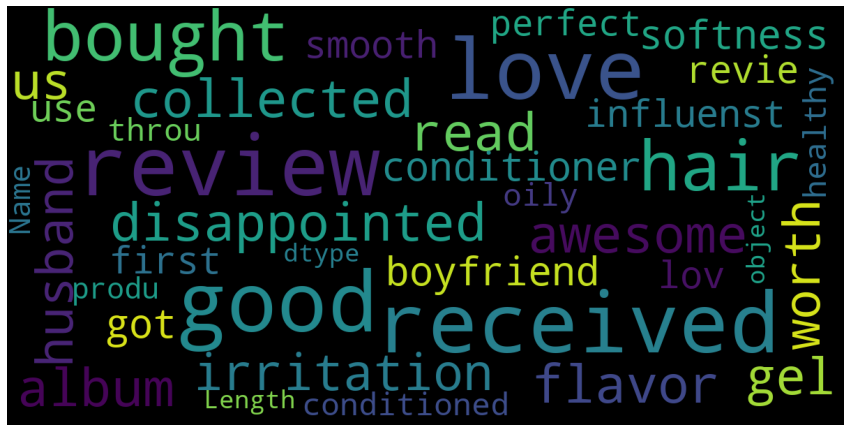

In [36]:
# Generate a word cloud image
show_wordcloud(recommend_df_master['reviews'])

In [37]:
# Getting some reviews text after pre-processing
recommend_df_master['reviews'].head()

0    just awesome i love this album its very good m...
1    good good flavor this review was collected as ...
3    disappointed i read through the reviews on her...
4    irritation my husband bought this gel for us t...
5    not worth it my boyfriend and i bought this to...
Name: reviews, dtype: object

## Stemming and Lemmatization

The goal of both stemming and lemmatization is to reduce inflectional forms and derivationally related forms of a word to a common base form.

In [38]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def word_lemmatizer(text):
    """ Function to apply the lemmatization
    """
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words("english")]
    lem_text = [lemmatizer.lemmatize(i) for i in words]
    lem_text = " ".join(lem_text)
    
    return lem_text

# Apply the lemmatization process to the reviews text column
recommend_df_master['reviews'] = [ word_lemmatizer(i) for i in recommend_df_master['reviews']]

In [39]:
recommend_df_master.head()

,id,reviews_username,name,reviews_rating,reviews,sentiment
0,AV13O1A8GV-KLJ3akUyj,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,awesome love album good hip hop side current p...,1
1,AV14LG0R-jtxr-f38QfS,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5,good good flavor review collected part promotion,1
3,AV16khLE-jtxr-f38VFn,rebecca,K-Y Love Sensuality Pleasure Gel,1,disappointed read review looking buying one co...,0
4,AV16khLE-jtxr-f38VFn,walker557,K-Y Love Sensuality Pleasure Gel,1,irritation husband bought gel u gel caused irr...,0
5,AV16khLE-jtxr-f38VFn,samantha,K-Y Love Sensuality Pleasure Gel,1,worth boyfriend bought spice thing bedroom hig...,0


In [40]:
def stemming_text(text):
    """ Function to apply the stemming
    """
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words("english")]
    stem_text = [stemmer.stem(i) for i in words]
    stem_text = " ".join(stem_text)
    
    return stem_text

# Apply the stemming to the reviews text column
recommend_df_master['reviews'] = [ stemming_text(i) for i in recommend_df_master['reviews']]

In [41]:
recommend_df_master.head()

,id,reviews_username,name,reviews_rating,reviews,sentiment
0,AV13O1A8GV-KLJ3akUyj,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,awesom love album good hip hop side current po...,1
1,AV14LG0R-jtxr-f38QfS,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5,good good flavor review collect part promot,1
3,AV16khLE-jtxr-f38VFn,rebecca,K-Y Love Sensuality Pleasure Gel,1,disappoint read review look buy one coupl lubr...,0
4,AV16khLE-jtxr-f38VFn,walker557,K-Y Love Sensuality Pleasure Gel,1,irrit husband bought gel u gel caus irrit felt...,0
5,AV16khLE-jtxr-f38VFn,samantha,K-Y Love Sensuality Pleasure Gel,1,worth boyfriend bought spice thing bedroom hig...,0


## Model Building

This is a supervised binary classification problem. We are trying to predict the sentiment based on the reviews left by customers in the e-commerce platform. We used Python’s Scikit Learn libraries to solve the problem. In this context, we implemented Logistic Regression, Random Forest and Naive Bayes algorithms.


In [42]:
# Split the dataframe into dependent and independent variables
X = recommend_df_master['reviews']
y = recommend_df_master['sentiment']

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
# Split the dataset into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

train_text_list=X_train.tolist()
test_text_list=X_test.tolist()

In [45]:
# Analyse the shape for the train and test datasets
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (20846,)
y_train (20846,)
X_test (8935,)
y_test (8935,)


## Feature Extraction 

In [46]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

tfidfconverter = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))

X_train = tfidfconverter.fit_transform(train_text_list).toarray()
X_test = tfidfconverter.transform(test_text_list).toarray()

In [47]:
# Count Vectorization

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english',max_features=5000)
vect.fit(train_text_list)

X_train_nb = vect.transform(train_text_list)
X_test_nb =vect.transform(test_text_list)

In [48]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score
from sklearn.metrics import confusion_matrix

In [49]:
evaluation_table = pd.DataFrame()

def evaluation_helper(confusion, stats):
    """ Helper function to evaluate the confusion matrix
    """
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    stats['Sensitivity'] = TP / float(TP+FN)
    stats['Precision'] = TP / float(TP + FP)
    stats['Specificity'] = TN / float(TN+FP)

    return stats

#### 1. Random Forest Classifier Model

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Build the RF model and predict
classifier = RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=10,
                                    n_estimators=100, random_state=42, n_jobs=-1)
classifier.fit(X_train, y_train)
pred1 = classifier.predict(X_test)

In [51]:
# Get the accuracy and confusion metrics
print("Random Forest Model accuracy", accuracy_score(pred1, y_test))
print(classification_report(pred1, y_test))
print(confusion_matrix(pred1, y_test))

Random Forest Model accuracy 0.7460548405148293
              precision    recall  f1-score   support

           0       0.63      0.25      0.36      2539
           1       0.76      0.94      0.84      6396

    accuracy                           0.75      8935
   macro avg       0.70      0.60      0.60      8935
weighted avg       0.72      0.75      0.70      8935

[[ 641 1898]
 [ 371 6025]]


In [52]:
metrics = dict()
metrics['Accuracy'] = accuracy_score(y_test, pred1)
stats = confusion_matrix(y_test, pred1)

In [53]:
# Get the evaluation table entry for the RF model
evaluation_table = evaluation_table.append(pd.Series(evaluation_helper(stats, metrics),name='RF Model'))
evaluation_table.head()

,Accuracy,Precision,Sensitivity,Specificity
RF Model,0.746055,0.941995,0.760444,0.633399


**Results**


*   Accuracy: 74.61%
*   Precision: 94.20%



#### 2. Logistic Regression Model



In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

# Build the LR model and predict
logit = LogisticRegression(random_state=42, C = 3.5, class_weight= 'balanced')
logit.fit(X_train, y_train)
pred2 = logit.predict(X_test)

In [55]:
# Get the accuracy and confusion metrics
print("Logistic Regression accuracy", accuracy_score(pred2, y_test))
print(classification_report(pred2, y_test))
print(confusion_matrix(pred2, y_test))

Logistic Regression accuracy 0.8611080022383883
              precision    recall  f1-score   support

           0       0.77      0.44      0.56      1789
           1       0.87      0.97      0.92      7146

    accuracy                           0.86      8935
   macro avg       0.82      0.70      0.74      8935
weighted avg       0.85      0.86      0.85      8935

[[ 780 1009]
 [ 232 6914]]


In [56]:
metrics = dict()
metrics['Accuracy'] = accuracy_score(y_test, pred2)
stats = confusion_matrix(y_test, pred2)

In [57]:
# Get the evaluation table entry for the LR model
evaluation_table = evaluation_table.append(pd.Series(evaluation_helper(stats, metrics),name='LR Model'))
evaluation_table.head()

,Accuracy,Precision,Sensitivity,Specificity
RF Model,0.746055,0.941995,0.760444,0.633399
LR Model,0.861108,0.967534,0.872649,0.770751


**Results**


*   Accuracy: 86.11%
*   Precision: 96.75%



#### 3. Multinomial Naive Bayes Model

In [58]:
# We use Count Vector for this model building

from sklearn.naive_bayes import MultinomialNB

# Build the Navive Bayes and predict
m_nb = MultinomialNB()
m_nb.fit(X_train_nb, y_train)

pred3 = m_nb.predict(X_test_nb)

In [59]:
# Get the accuracy and confusion metrics
print("Multinomial NB accuracy", accuracy_score(pred3, y_test))
print(classification_report(pred3, y_test))
print(confusion_matrix(pred3, y_test))

Multinomial NB accuracy 0.8775601566871852
              precision    recall  f1-score   support

           0       0.32      0.44      0.37       736
           1       0.95      0.92      0.93      8199

    accuracy                           0.88      8935
   macro avg       0.64      0.68      0.65      8935
weighted avg       0.90      0.88      0.89      8935

[[ 327  409]
 [ 685 7514]]


In [60]:
metrics = dict()
metrics['Accuracy'] = accuracy_score(y_test, pred3)
stats = confusion_matrix(y_test, pred3)

In [61]:
# Get the evaluation table entry for the Naive Bayes model
evaluation_table = evaluation_table.append(pd.Series(evaluation_helper(stats, metrics),name='Multinomial NB Model'))
evaluation_table.head()

,Accuracy,Precision,Sensitivity,Specificity
RF Model,0.746055,0.941995,0.760444,0.633399
LR Model,0.861108,0.967534,0.872649,0.770751
Multinomial NB Model,0.877560,0.916453,0.948378,0.323123


**Results**


*   Accuracy: 87.76%
*   Precision: 91.64%

In [62]:
recommend_df_master['sentiment'].value_counts()

1    26439
0     3342
Name: sentiment, dtype: int64

We can see that the dataset that we have is imbalanced one. The number of positive reviews are very high compared to the negative reviews in the given dataset. So we need to balance these dataset before proceeds for other model building.

#### Using SMOTE Technique

In [63]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print('Pre SMOTE', Counter(y_train))
smt = SMOTE()
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
print('Post Smote', Counter(y_train_smt))

Pre SMOTE Counter({1: 18516, 0: 2330})
Post Smote Counter({1: 18516, 0: 18516})


In [64]:
# Apply the same of Count vectorised dataset for NB model building

print('Pre SMOTE', Counter(y_train))
smt = SMOTE()
X_train_nbsmt, y_train_nbsmt = smt.fit_resample(X_train_nb, y_train)

print('Post Smote', Counter(y_train_nbsmt))

Pre SMOTE Counter({1: 18516, 0: 2330})
Post Smote Counter({1: 18516, 0: 18516})


#### 4. Random Forest Classifier Model with Balanced Data

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Build the RF model and predict on balanced dataset
classifier = RandomForestClassifier(
    class_weight='balanced',
    max_depth=4,
    max_features=10,
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
classifier.fit(X_train_smt, y_train_smt)
pred4 = classifier.predict(X_test)

In [66]:
# Get the accuracy and confusion metrics
print("Random Forest Model accuracy", accuracy_score(pred4, y_test))
print(classification_report(pred4, y_test))
print(confusion_matrix(pred4, y_test))

Random Forest Model accuracy 0.7911583659764969
              precision    recall  f1-score   support

           0       0.40      0.24      0.30      1658
           1       0.84      0.92      0.88      7277

    accuracy                           0.79      8935
   macro avg       0.62      0.58      0.59      8935
weighted avg       0.76      0.79      0.77      8935

[[ 402 1256]
 [ 610 6667]]


In [67]:
metrics = dict()
metrics['Accuracy'] = accuracy_score(y_test, pred4)
stats = confusion_matrix(y_test, pred4)

# Get the evaluation table entry for the RF model with Balanced dataset
evaluation_table = evaluation_table.append(pd.Series(evaluation_helper(stats, metrics),name='RF Model Balanced'))
evaluation_table.head()


,Accuracy,Precision,Sensitivity,Specificity
RF Model,0.746055,0.941995,0.760444,0.633399
LR Model,0.861108,0.967534,0.872649,0.770751
Multinomial NB Model,0.877560,0.916453,0.948378,0.323123
RF Model Balanced,0.791158,0.916174,0.841474,0.397233


**Results**


*   Accuracy: 80.03%
*   Precision: 91.65%

#### 5. Logistic Regression Model with Balanced Data

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

# Build the LR model and predict on balanced dataset
logit_bal = LogisticRegression(random_state=42, C = 3.5, class_weight= 'balanced')
logit_bal.fit(X_train_smt, y_train_smt)
pred5 = logit_bal.predict(X_test)

In [69]:
# Get the accuracy and confusion metrics
print("Logistic Regression accuracy", accuracy_score(pred5, y_test))
print(classification_report(pred5, y_test))
print(confusion_matrix(pred5, y_test))

Logistic Regression accuracy 0.8670397313933967
              precision    recall  f1-score   support

           0       0.73      0.45      0.56      1660
           1       0.88      0.96      0.92      7275

    accuracy                           0.87      8935
   macro avg       0.81      0.70      0.74      8935
weighted avg       0.86      0.87      0.85      8935

[[ 742  918]
 [ 270 7005]]


In [70]:
metrics = dict()
metrics['Accuracy'] = accuracy_score(y_test, pred5)
stats = confusion_matrix(y_test, pred5)

# Get the evaluation table entry for the LR model with Balanced dataset
evaluation_table = evaluation_table.append(pd.Series(evaluation_helper(stats, metrics), name='LR Model Balanced'))
evaluation_table.head()

,Accuracy,Precision,Sensitivity,Specificity
RF Model,0.746055,0.941995,0.760444,0.633399
LR Model,0.861108,0.967534,0.872649,0.770751
Multinomial NB Model,0.877560,0.916453,0.948378,0.323123
RF Model Balanced,0.791158,0.916174,0.841474,0.397233
LR Model Balanced,0.867040,0.962887,0.884135,0.733202


**Results**


*   Accuracy: 86.79%
*   Precision: 96.27%

#### 6. Multinomial Naive Bayes on Balanced Dataset

In [73]:
# Evaluating based on CountVectoriser
from sklearn.naive_bayes import MultinomialNB

# Build the MNB model and predict on balanced dataset
m_nb = MultinomialNB()
m_nb.fit(X_train_nbsmt, y_train_nbsmt)

pred6 = m_nb.predict(X_test_nb)

In [74]:
# Get the accuracy and confusion metrics
print("Multinomial NB accuracy", accuracy_score(pred6, y_test))
print(classification_report(pred6, y_test))
print(confusion_matrix(pred6, y_test))

Multinomial NB accuracy 0.8091773922775601
              precision    recall  f1-score   support

           0       0.46      0.29      0.35      1625
           1       0.85      0.93      0.89      7310

    accuracy                           0.81      8935
   macro avg       0.66      0.61      0.62      8935
weighted avg       0.78      0.81      0.79      8935

[[ 466 1159]
 [ 546 6764]]


In [75]:
metrics = dict()
metrics['Accuracy'] = accuracy_score(y_test, pred6)
stats = confusion_matrix(y_test, pred6)

# Get the evaluation table entry for the MNB model with Balanced dataset
evaluation_table = evaluation_table.append(pd.Series(evaluation_helper(stats, metrics),name='Multinomial NB Model Balanced'))
evaluation_table.head(6)

,Accuracy,Precision,Sensitivity,Specificity
RF Model,0.746055,0.941995,0.760444,0.633399
LR Model,0.861108,0.967534,0.872649,0.770751
Multinomial NB Model,0.877560,0.916453,0.948378,0.323123
RF Model Balanced,0.791158,0.916174,0.841474,0.397233
LR Model Balanced,0.867040,0.962887,0.884135,0.733202
Multinomial NB Model Balanced,0.809177,0.925308,0.853717,0.460474


**Results**


*   Accuracy: 81.14%
*   Precision: 92.54%

## Observations or Other Findings

If I use the Y column as "Rating" rather than "user_sentiment" and run all the above models, I will get the below results.
<br>
In the above case, we have modified the "sentiment" column to look like this;


```
recommend_df_master['sentiment'] = recommend_df_master['reviews_rating'].map(lambda x: 1 if x >=3 else 0)
```
Any product which has got rating greater than 3, we considered it as Postive and others as Negative sentiment


In [76]:
evaluation_table = evaluation_table.append(pd.Series(evaluation_helper(stats, metrics),name='RF Model Tuned Balanced'))
evaluation_table.head(15)


,Accuracy,Precision,Sensitivity,Specificity
RF Model,0.746055,0.941995,0.760444,0.633399
LR Model,0.861108,0.967534,0.872649,0.770751
Multinomial NB Model,0.877560,0.916453,0.948378,0.323123
RF Model Balanced,0.791158,0.916174,0.841474,0.397233
LR Model Balanced,0.867040,0.962887,0.884135,0.733202
Multinomial NB Model Balanced,0.809177,0.925308,0.853717,0.460474
RF Model Tuned Balanced,0.809177,0.925308,0.853717,0.460474


##### Conclusion
- For this project, we are not choosing to go with the above approach, we will go with the "**user_sentiment**" column for now rather than "**reviews_rating**" column.

## Hyperparameter Tuning

#### 7. Random Forest Model with hyperparamter tuning

---



In [77]:
# Lets tune RF model which has imbalance
from sklearn.model_selection import GridSearchCV
%time

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1,class_weight="balanced")
# Create the parameter grid based on the results
params = {
    'max_depth': [4,5,10,15],
    'min_samples_leaf': [5, 10, 20],
    'max_features': [10,20],
    'n_estimators': [30, 50,60]
}

# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator=classifier_rf, param_grid=params, 
    cv=4, n_jobs=-1, verbose=1, scoring="recall"
)
grid_search.fit(X_train, y_train)
rf2 = grid_search.best_estimator_

pred7 = rf2.predict(X_test)


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  1.6min finished


In [78]:
# Get the accuracy and confusion metrics
print("Random Forest Model accuracy", accuracy_score(pred7, y_test))
print(classification_report(pred7, y_test))
print(confusion_matrix(pred7, y_test))

Random Forest Model accuracy 0.8142137660884163
              precision    recall  f1-score   support

           0       0.69      0.34      0.46      2042
           1       0.83      0.95      0.89      6893

    accuracy                           0.81      8935
   macro avg       0.76      0.65      0.67      8935
weighted avg       0.80      0.81      0.79      8935

[[ 697 1345]
 [ 315 6578]]


In [79]:
# Get the evaluation table entry for the RF model with hyperparameter tuning (Imbalanced data)
evaluation_table = evaluation_table.append(pd.Series(evaluation_helper(stats, metrics),name='RF Model Tuned'))
evaluation_table.head(10)

,Accuracy,Precision,Sensitivity,Specificity
RF Model,0.746055,0.941995,0.760444,0.633399
LR Model,0.861108,0.967534,0.872649,0.770751
Multinomial NB Model,0.877560,0.916453,0.948378,0.323123
RF Model Balanced,0.791158,0.916174,0.841474,0.397233
LR Model Balanced,0.867040,0.962887,0.884135,0.733202
Multinomial NB Model Balanced,0.809177,0.925308,0.853717,0.460474
RF Model Tuned Balanced,0.809177,0.925308,0.853717,0.460474
RF Model Tuned,0.809177,0.925308,0.853717,0.460474


**Results**


*   Accuracy: 81.14%
*   Precision: 92.54%

#### 8. Random Forest Model with hyperparamter tuning on Balanced data


In [80]:
# Lets tune RF model which has no imbalance
from sklearn.model_selection import GridSearchCV
%time

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1,class_weight="balanced")
# Create the parameter grid based on the results
params = {
    'max_depth': [4,5,10,15],
    'min_samples_leaf': [5, 10, 20],
    'max_features': [10,20],
    'n_estimators': [30, 50,60]
}

# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator=classifier_rf, param_grid=params, 
    cv=4, n_jobs=-1, verbose=1, scoring = "recall"
)
grid_search.fit(X_train_smt, y_train_smt)
rf2 = grid_search.best_estimator_

pred8 = rf2.predict(X_test)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.9min finished


In [81]:
# Get the accuracy and confusion metrics
print("Random Forest Model accuracy", accuracy_score(pred8, y_test))
print(classification_report(pred8, y_test))
print(confusion_matrix(pred8, y_test))

Random Forest Model accuracy 0.8317851147174035
              precision    recall  f1-score   support

           0       0.45      0.32      0.38      1401
           1       0.88      0.93      0.90      7534

    accuracy                           0.83      8935
   macro avg       0.67      0.63      0.64      8935
weighted avg       0.81      0.83      0.82      8935

[[ 455  946]
 [ 557 6977]]


In [82]:
# Get the evaluation table entry for the RF model with hyperparameter tuning (balanced data)
evaluation_table = evaluation_table.append(pd.Series(evaluation_helper(stats, metrics),name='RF Model Tuned Balanced'))
evaluation_table.head(15)


,Accuracy,Precision,Sensitivity,Specificity
RF Model,0.746055,0.941995,0.760444,0.633399
LR Model,0.861108,0.967534,0.872649,0.770751
Multinomial NB Model,0.877560,0.916453,0.948378,0.323123
RF Model Balanced,0.791158,0.916174,0.841474,0.397233
LR Model Balanced,0.867040,0.962887,0.884135,0.733202
Multinomial NB Model Balanced,0.809177,0.925308,0.853717,0.460474
RF Model Tuned Balanced,0.809177,0.925308,0.853717,0.460474
RF Model Tuned,0.809177,0.925308,0.853717,0.460474
RF Model Tuned Balanced,0.809177,0.925308,0.853717,0.460474


**Results**


*   Accuracy: 81.14%
*   Precision: 92.54%

**Observations**
- From the table, we can select the best model as Logistic Regression Model with balanced data.
- Accuracy of 86.79% and Precision of 96.27%

In [83]:
# Pickling the best model
import pickle

# Save the the vectorizer and the logistic regression model
# It will be useful for us when we want to predict

pickle.dump(tfidfconverter, open('./vectorizer.pkl','wb'))
pickle.dump(logit_bal, open('./model.pkl','wb'))
recommend_df_master.to_pickle('./cleaned_text_data', compression='zip')

## Product Recommendation

We will get the top 15 products from the Recommendation system.
We are going to evaluate two different systems;
- User-based Recommendation system
- Item-based Recommendation system


In [84]:
recommend_df_master.head()

,id,reviews_username,name,reviews_rating,reviews,sentiment
0,AV13O1A8GV-KLJ3akUyj,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,awesom love album good hip hop side current po...,1
1,AV14LG0R-jtxr-f38QfS,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5,good good flavor review collect part promot,1
3,AV16khLE-jtxr-f38VFn,rebecca,K-Y Love Sensuality Pleasure Gel,1,disappoint read review look buy one coupl lubr...,0
4,AV16khLE-jtxr-f38VFn,walker557,K-Y Love Sensuality Pleasure Gel,1,irrit husband bought gel u gel caus irrit felt...,0
5,AV16khLE-jtxr-f38VFn,samantha,K-Y Love Sensuality Pleasure Gel,1,worth boyfriend bought spice thing bedroom hig...,0


In [85]:
# Create a new dataframe with required columns
df_recommend = pd.DataFrame(data = recommend_df_master[['reviews_username','id','reviews_rating']])
# Get the top 5 rows
df_recommend.head()

,reviews_username,id,reviews_rating
0,joshua,AV13O1A8GV-KLJ3akUyj,5
1,dorothy w,AV14LG0R-jtxr-f38QfS,5
3,rebecca,AV16khLE-jtxr-f38VFn,1
4,walker557,AV16khLE-jtxr-f38VFn,1
5,samantha,AV16khLE-jtxr-f38VFn,1


In [86]:
# Removing the duplicates before performing the recommendation system
df_recommend = df_recommend.groupby(['reviews_username','id'],as_index=False).agg({'reviews_rating': pd.Series.mode,'reviews_rating':np.mean})

In [87]:
# Updating column names for better understanding
df_recommend['username'] = df_recommend['reviews_username']
df_recommend['product'] = df_recommend['id']
df_recommend['rating'] = round(df_recommend['reviews_rating'],1)

# Remove the old columns
df_recommend = df_recommend.drop(['reviews_username','id','reviews_rating'],axis=1)
df_recommend.head()

,username,product,rating
0,00dog3,AVpe6FfKilAPnD_xQmHi,4.0
1,00sab00,AVpe41TqilAPnD_xQH3d,1.0
2,00sab00,AVpe59io1cnluZ0-ZgDU,3.0
3,01impala,AVpfPaoqLJeJML435Xk9,3.0
4,02dakota,AVpfPaoqLJeJML435Xk9,5.0


In [88]:
# Split the data into train and test sets
train, test = train_test_split(df_recommend, test_size=0.2, random_state=42)

# Shape of test and train sets
print(train.shape)
print(test.shape)

(22070, 3)
(5518, 3)


In [89]:
# Apply pivot for user ratings for each product
# Apply '0' wherever rating is not provided by the user
df_product_features = train.pivot(
    index='username',
    columns='product',
    values='rating'
).fillna(0)


In [90]:
# Get the top few rows
df_product_features.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,...,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Preparing Dataset for Recommendation Systems


- Dummy train will be used for prediction of the products which has not been rated by the user. The products not rated by user is marked as 1 for prediction.

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user.

In [91]:
# Create dummy train and test copy
dummy_train = train.copy()
dummy_test = test.copy()

In [92]:
# Update the rating to 0 if the user is provided rating
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x >= 1 else 1)

# Update the rating to 1 if the user is provided rating
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x >= 1 else 0)

In [93]:
# Products not rated as marked as 1 for prediction
dummy_train = dummy_train.pivot(
    index='username',
    columns='product',
    values='rating'
).fillna(1)

# Products not rated as marked as 0 for evaluation
dummy_test = dummy_test.pivot(
    index='username',
    columns='product',
    values='rating'
).fillna(0)

In [94]:
# Get the top few rows
dummy_train.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,...,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [95]:
# Get the top few rows from dummy_test
dummy_test.head()

product,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,...,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123cat123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123too,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Item Based Recommendation System

In [96]:
# Get the transpose of the reviews matrix
product_features = train.pivot(
    index='username',
    columns='product',
    values='rating'
).T

product_features.head()

username,00dog3,00sab00,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,11677j,1234,1234561,1234567,1234asdf,123charlie,123numbers,123rs,123soccermom,12cass12,12gage,132457,13ram,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1616,1753,18612,1863philly,1943,1950rmm,1970,1992firebirdgirl,19bubba67,...,zipper,zippity,zippy,zitro,zittles,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zoeellasca,zoey,zoeyny,zokhid,zombie,zombiedad80,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoomin76,zowie,zozo0o,zpalma,zsarah,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
product,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
# Normalise the product rating
mean = np.nanmean(product_features, axis=1)
df_subtracted = (product_features.T-mean).T

In [98]:
df_subtracted.head()

username,00dog3,00sab00,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,11677j,1234,1234561,1234567,1234asdf,123charlie,123numbers,123rs,123soccermom,12cass12,12gage,132457,13ram,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1616,1753,18612,1863philly,1943,1950rmm,1970,1992firebirdgirl,19bubba67,...,zipper,zippity,zippy,zitro,zittles,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zoeellasca,zoey,zoeyny,zokhid,zombie,zombiedad80,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoomin76,zowie,zozo0o,zpalma,zsarah,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
product,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.125483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Cosine Similarity

- Cosine Similarity is a measurement that quantifies the similarity between two vectors

#####Adjusted Cosine

- Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes.
- In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different products.

In [99]:
# Calculate the cosine similarity
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [100]:
# Get the correlation only for value greater than 0. (Positively correlated)
item_correlation[item_correlation <0 ] = 0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

####Prediction

In [101]:
item_predicted_ratings = np.dot((product_features.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.03394486,
        0.        ],
       [0.        , 0.        , 0.00982061, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00254369],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05657476,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00508738]])

In [102]:
item_predicted_ratings.shape

(20257, 256)

In [103]:
dummy_train.shape

(20257, 256)

####Get the rating for the products not rated by the user for recommendation

In [104]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,...,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.033400,0.000000,0.000000,0.013887,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
00sab00,0.0,0.0,0.000000,0.008822,0.0,0.0,0.0,0.006428,0.0,0.005525,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.003664,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.010821,0.0,0.0,0.0,0.000000,0.013017,0.029152,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022375,0.000000,0.007548,0.000076,0.0,0.012259,0.003868,0.0,0.013147,0.0,0.0,0.0,0.031130,0.005433,0.0,0.033945,0.000000
02dakota,0.0,0.0,0.009821,0.000000,0.0,0.0,0.0,0.000000,0.0,0.008014,0.0,0.0,0.0,0.0,0.000556,0.000580,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.008914,0.012399,0.000000,0.001175,0.0,0.018238,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.001304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.005046,0.000000,0.010119,0.0,0.000000,0.001681,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
02deuce,0.0,0.0,0.007856,0.000000,0.0,0.0,0.0,0.000000,0.0,0.006411,0.0,0.0,0.0,0.0,0.000445,0.000464,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.007131,0.009919,0.000000,0.000940,0.0,0.014591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.001044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.004037,0.000000,0.008095,0.0,0.000000,0.001345,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
06stidriver,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.002011,0.0,0.003457,0.0,0.0,0.0,0.0,0.002480,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000348,0.0,0.0,0.0,0.0,0.0,0.0,0.009499,0.000000,0.0,0.0,0.0,0.001517,0.000000,0.000000,0.000117,0.0,0.002995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01062,0.0,0.0,0.0,0.0,0.0,0.0,0.0037,0.006747,0.0,0.0,0.0,0.0,0.0,

#### Get the Top 20 Prediction for a user

In [105]:
results = item_final_rating.iloc[1].sort_values(ascending=False)[0:20]
results

product
AVpfE7puilAPnD_xUcCW    0.124976
AVpfRoqcLJeJML436FqG    0.112669
AVpfPnrU1cnluZ0-g9rL    0.082716
AVpfNc9cLJeJML434tza    0.054795
AVpfQtEm1cnluZ0-hUpe    0.053933
AVpfJcHuLJeJML433ZrY    0.053605
AVpe7sl91cnluZ0-aI1Y    0.038708
AVpfv4TlilAPnD_xhjNS    0.033945
AVpfthSailAPnD_xg3ON    0.031130
AVpe_dxlilAPnD_xSiHI    0.030361
AVpe4pnBilAPnD_xQDeb    0.029152
AVpe_pDG1cnluZ0-bjSf    0.027889
AVpf0thK1cnluZ0-r8vR    0.026124
AVpfOmKwLJeJML435GM7    0.025497
AVpfoSS51cnluZ0-oVH9    0.022375
AVpe6FfKilAPnD_xQmHi    0.018765
AVpf9_3MLJeJML43GvdB    0.017159
AVpfRTh1ilAPnD_xYic2    0.016457
AVpe6n2_LJeJML43yOgE    0.015266
AVpf4WWN1cnluZ0-s7Wj    0.013607
Name: 00sab00, dtype: float64

In [106]:
# Get the product names
d = pd.merge(results , recommend_df_master,left_on='product',right_on='id', how = 'left')
d.head()

,00sab00,id,reviews_username,name,reviews_rating,reviews,sentiment
0,0.124976,AVpfE7puilAPnD_xUcCW,mike,Bilbao Nightstand Gray Oak - South Shore,1,horribl construct 1 product miss piec screw na...,1
1,0.124976,AVpfE7puilAPnD_xUcCW,savvy guy,Bilbao Nightstand Gray Oak - South Shore,3,purrti believ meant kid room adult love guest ...,1
2,0.124976,AVpfE7puilAPnD_xUcCW,savvyguy,Bilbao Nightstand Gray Oak - South Shore,3,purrti believ meant kid room adult love guest ...,1
3,0.124976,AVpfE7puilAPnD_xUcCW,atshead,Bilbao Nightstand Gray Oak - South Shore,4,beauti finish build bought set wed exactli sty...,1
4,0.124976,AVpfE7puilAPnD_xUcCW,javier,Bilbao Nightstand Gray Oak - South Shore,5,beauti need nightstand girlfriend one terribl ...,1


###Evaluation
- Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

In [107]:
test_product_features = test.pivot(
    index='username',
    columns='product',
    values='rating'
).T

mean = np.nanmean(test_product_features, axis=1)
test_df_subtracted = (test_product_features.T-mean).T

test_item_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_item_correlation[np.isnan(test_item_correlation)] = 0
test_item_correlation[test_item_correlation<0]=0

In [108]:
test_item_correlation.shape

(204, 204)

In [109]:
test_product_features.shape

(204, 5372)

In [110]:
test_item_predicted_ratings = (np.dot(test_item_correlation, test_product_features.fillna(0))).T
test_item_final_rating = np.multiply(test_item_predicted_ratings,dummy_test)
test_item_final_rating.head()

product,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,...,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123cat123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123too,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
test_ = test.pivot(
    index='username',
    columns='product',
    values='rating'
)

In [112]:
# Process to get the RMSE value
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_item_final_rating.copy() 
X = X[X > 0]
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))


test_ = test.pivot(
    index='username',
    columns='product',
    values='rating'
)

# Get the total NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

MinMaxScaler(copy=True, feature_range=(1, 5))


In [113]:
# Get the RMSE value
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
rmse

0.31615406892183007

## UserBased Recommendation System

In [114]:
# Convert the train dataset into matrix format.
df_pivot_u1 = train.pivot(
    index='username',
    columns='product',
    values='rating'
).fillna(0)

df_pivot_u1.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,...,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
df_pivot_u1.shape

(20257, 256)

In [116]:
dummy_train = train.copy()

In [117]:
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x >= 1 else 1)

In [118]:
# Convert the dummy_train dataset into matrix format.
dummy_train = dummy_train.pivot(
    index='username',
    columns='product',
    values='rating'
).fillna(1)

In [119]:
dummy_train.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,...,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#####Cosine Similarity

In [120]:
from sklearn.metrics.pairwise import pairwise_distances

# Get the User Similarity matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot_u1, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.        ... 0.        0.9486833 0.       ]
 [0.        0.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.        0.9486833 0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]


In [121]:
user_correlation.shape

(20257, 20257)

##### Prediction
Predicting for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users.

In [122]:
user_correlation[user_correlation < 0] = 0
user_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 0.       , ..., 0.       , 0.9486833,
        0.       ],
       [0.       , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.       , 0.9486833, 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

In [123]:
user_pred_ratings = np.dot(user_correlation, df_pivot_u1.fillna(0))
user_pred_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.31008684, ..., 0.        , 2.08615219,
        0.66421116],
       [0.        , 0.        , 4.89045722, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.47673129, ..., 0.        , 0.        ,
        3.53553391],
       [0.        , 0.        , 0.        , ..., 0.        , 2.19899749,
        0.70014004],
       [0.        , 0.        , 0.47673129, ..., 0.        , 0.        ,
        3.53553391]])

In [124]:
# We are interested in the product not rated by the user
# We will ignore the product rated by the user by making it zero.

user_final_rating = np.multiply(user_pred_ratings, dummy_train)
user_final_rating.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,...,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,5.614476,0.000000,0.000000,2.105380,0.0,0.000000,...,0.0,3.123475,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
00sab00,0.0,0.0,0.310087,14.458901,0.0,0.0,0.0,1.677051,0.440415,2.738765,0.0,0.0,0.0,0.0,1.429572,2.359088,0.000000,0.0,0.0,0.0,0.0,0.0,2.168419,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,21.848405,0.0,0.0,0.0,0.000000,2.088038,0.344656,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.012461,0.000000,0.0,0.0,0.778499,3.623879,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,6.058440,5.445762,0.755929,1.955548,0.0,2.212195,2.51837,0.0,2.738613,0.000000,1.854775,0.0,3.034191,2.970043,0.0,2.086152,0.664211
02dakota,0.0,0.0,4.890457,23.041171,0.0,0.0,0.0,0.000000,2.380382,1.766904,0.0,0.0,0.0,0.0,1.353135,1.353135,5.319299,0.0,0.0,0.0,0.0,0.0,2.208631,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,24.215600,0.0,0.0,0.0,132.691742,1.737620,0.000000,67.128376,0.0,6.023127,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.541664,0.0,0.0,0.000000,2.886751,0.0,0.0,0.000000,7.955127,0.0,0.0,0.0,2.46183,0.0,0.0,0.96225,5.378085,6.043298,4.042250,7.261096,0.0,5.648672,4.19945,0.0,0.000000,1.555428,1.450894,0.0,0.000000,3.269376,0.0,0.000000,0.000000
02deuce,0.0,0.0,4.890457,23.041171,0.0,0.0,0.0,0.000000,2.380382,1.766904,0.0,0.0,0.0,0.0,1.353135,1.353135,5.319299,0.0,0.0,0.0,0.0,0.0,2.208631,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,24.215600,0.0,0.0,0.0,132.691742,1.737620,0.000000,67.128376,0.0,6.023127,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.541664,0.0,0.0,0.000000,2.886751,0.0,0.0,0.000000,7.955127,0.0,0.0,0.0,2.46183,0.0,0.0,0.96225,5.378085,6.043298,4.042250,7.261096,0.0,5.648672,4.19945,0.0,0.000000,1.555428,1.450894,0.0,0.000000,3.269376,0.0,0.000000,0.000000
06stidriver,0.0,0.0,0.476731,7.482763,0.0,0.0,0.0,3.535534,0.000000,4.434558,0.0,0.0,0.0,0.0,1.537654,2.518234,0.000000,0.0,0.0,0.0,0.0,0.0,12.578200,

In [125]:
common = test[test.username.isin(train.username)]
common.shape

(813, 3)

In [126]:
common.head()

,username,product,rating
6593,dani,AVpf2tw1ilAPnD_xjflC,5.0
12463,john,AVpf0eb2LJeJML43EVSt,4.0
10935,jack,AVpf99c6LJeJML43Gu3K,5.0
11072,james,AVpf2tw1ilAPnD_xjflC,4.0
17342,mhayser,AVpf3VOfilAPnD_xjpun,5.0


In [127]:
# Creating a common pivot table (matrix format)
common_user_user_matrix = common.pivot_table(index='username', columns='product', values='rating')
common_user_user_matrix.shape

(715, 108)

In [128]:
common_user_user_matrix.head()

product,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe78stLJeJML43ytOY,AVpe7sl91cnluZ0-aI1Y,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf0O60ilAPnD_xizE6,AVpf0eb2LJeJML43EVSt,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,...,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfi79RLJeJML43_Jo0,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfkIiYilAPnD_xeEjr,AVpfkak01cnluZ0-nJj6,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfshNsLJeJML43CB8q
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abbey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acg1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
# Getting the user correlation 
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.shape

(20257, 20257)

In [130]:
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,20217,20218,20219,20220,20221,20222,20223,20224,20225,20226,20227,20228,20229,20230,20231,20232,20233,20234,20235,20236,20237,20238,20239,20240,20241,20242,20243,20244,20245,20246,20247,20248,20249,20250,20251,20252,20253,20254,20255,20256
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0,0.0,0.0,0.0,0.209427,0.0,0.0,0.0,0.223607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.316228,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316228,0.0,0.0,0.948683,0.0,0.316228,0.0,0.0,0.0,0.0,0.0,0.0,0.316228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.529813,0.0,0.0,0.0,0.707107,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.514496,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.529813,0.0,0.0,0.0,0.707107,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.514496,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.000000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.624695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.000000,1.0


In [131]:
# Create the column with the index values which is the username
user_correlation_df['username'] = df_pivot_u1.index
user_correlation_df.set_index('username', inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,20217,20218,20219,20220,20221,20222,20223,20224,20225,20226,20227,20228,20229,20230,20231,20232,20233,20234,20235,20236,20237,20238,20239,20240,20241,20242,20243,20244,20245,20246,20247,20248,20249,20250,20251,20252,20253,20254,20255,20256
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0,0.0,0.0,0.0,0.209427,0.0,0.0,0.0,0.223607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.316228,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316228,0.0,0.0,0.948683,0.0,0.316228,0.0,0.0,0.0,0.0,0.0,0.0,0.316228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948683,0.0
02dakota,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.529813,0.0,0.0,0.0,0.707107,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.514496,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
02deuce,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.529813,0.0,0.0,0.0,0.707107,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.514496,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
06stidriver,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.000000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.624695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.000000,1.0


In [132]:
common.head()

,username,product,rating
6593,dani,AVpf2tw1ilAPnD_xjflC,5.0
12463,john,AVpf0eb2LJeJML43EVSt,4.0
10935,jack,AVpf99c6LJeJML43Gu3K,5.0
11072,james,AVpf2tw1ilAPnD_xjflC,4.0
17342,mhayser,AVpf3VOfilAPnD_xjpun,5.0


In [133]:
# Updating the column names
list_name = common.username.tolist()
user_correlation_df.columns = df_pivot_u1.index.tolist()
# Getting the user correlation matexi where only the common usernames are present
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [134]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [135]:
# Getting the transpose to get the User vs Product matrix
user_correlation_df_3 = user_correlation_df_2.T

In [136]:
user_correlation_df_3.head()

,1234,1witch,abbey,abby,acg1,acjuarez08,acv4217,adelynsmom,adriana,adriana9999,ajay,ajune,aktcharlotte,alarm,alex,alexis,allison33,ally,amazing,amber,amor,amy1,ang32,angel,angie,angiesmessykids,animallover,anna,anne,annie,april,arcticfox,aria,arlingtondonna,artteacher,as123,ash4,ash82085,audra,autumn,...,turi,turtleboy,tweetyanne,twiggy575,twin,tyler,unicorn351,unnamed,val,valerie,vccaan,venus24,vet323tech,vette,vicki,vickie,vicky,viking80,vivi37,wally,walt,warren,wendy59,wheezie,whome,wildman,winniepoo2,wiseman378,wolverine,wonderwoman,wonster67,woody,worm,xavier,yohnie1,yummy,yvonne,zipper,zippy,zitro
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.529813,0.529813,0.38834,0.0,0.0,0.0,0.260862,0.000000,0.0,0.662266,0.0,0.514900,0.423362,0.0,0.0,0.0,0.263592,0.0,0.0,0.529813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.529813,0.0,0.662266,0.0,0.0,0.0,0.0,0.529813,0.0,0.469409,0.0,0.0,0.0,0.0,0.260862,0.0,0.0,0.0,0.0,0.0,0.529813,0.0,0.529813,0.529813,0.0,0.529813,0.842927,0.0,0.0,0.0,0.0,0.529813,0.529813,0.0,0.662266
1witch,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.5,0.000000,0.000000,0.0,0.000000,0.0,0.431934,0.431934,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
abbey,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.707107,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.5,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
abby,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.196116,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
acg1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000


In [137]:
user_correlation_df_3.shape

(715, 715)

In [138]:
# Getting only those user having positive positive correlation
# We are setting all other entries as 0
user_correlation_df_3[user_correlation_df_3 < 0] = 0
common_user_pred_ratings = np.dot(user_correlation_df_3, common_user_user_matrix.fillna(0))
common_user_pred_ratings

array([[0.33097152, 3.44044766, 0.        , ..., 0.        , 0.42336202,
        0.        ],
       [0.        , 1.80893651, 0.        , ..., 0.        , 0.43193421,
        0.        ],
       [0.        , 1.80893651, 0.        , ..., 1.41421356, 4.        ,
        0.        ],
       ...,
       [0.62469505, 4.12347524, 0.        , ..., 0.        , 0.25916053,
        0.        ],
       [0.        , 1.41421356, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.89618185, 0.        , ..., 0.        , 0.43193421,
        0.        ]])

In [139]:
# Create the dummy test for evaluation
dummy_test = common.copy()
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='username', columns='product', values='rating').fillna(0)

In [140]:
dummy_test.shape

(715, 108)

In [141]:
common_user_user_matrix.head()

product,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe78stLJeJML43ytOY,AVpe7sl91cnluZ0-aI1Y,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf0O60ilAPnD_xizE6,AVpf0eb2LJeJML43EVSt,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,...,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfi79RLJeJML43_Jo0,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfkIiYilAPnD_xeEjr,AVpfkak01cnluZ0-nJj6,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfshNsLJeJML43CB8q
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1witch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abbey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
abby,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acg1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
common_user_pred_ratings = np.multiply(common_user_pred_ratings, dummy_test)

In [143]:
# Calculating the RMSE value
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_pred_ratings.copy() 
X = X[X > 0]
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))
y

MinMaxScaler(copy=True, feature_range=(1, 5))


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [144]:
common_ = common.pivot_table(index='username', columns='product', values='rating')

In [145]:
# Getting the total number of non-nan values
total_non_nan = np.count_nonzero(~np.isnan(y))

In [146]:
# Calculate the RMSE value
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
rmse

2.084088222367348

#### Results
- RMSE User- User Based: 2.08
- RMSE Item-Item Based: 0.32


From the evaluation metrics table we can say that **Item-Item based recommendation engine** is well suited for our analysis

##### Fine Tuning the Item-Item Based Recommendation System for the deploying

In [147]:
## Checking the shape of the final recommendations
item_final_rating.shape

(20257, 256)

In [148]:
final_pred_df = pd.DataFrame()
for i in np.arange(0,20257):  
    # Get the top 15 products for each user
    df = item_final_rating.iloc[i].sort_values(ascending=False)[:20]

    # Remove the products which dont have any weightage calculated
    product_id = np.array(df.index[df.values != 0])
    user_name = item_final_rating.iloc[i].name

    # Store in data frame at user_name and product
    sorted_user_predictions = pd.DataFrame({'product_id':product_id,'user_name':user_name})
    sorted_user_predictions.assign(product_id=sorted_user_predictions.product_id.str.split(",")).explode("product_id")

    sorted_user_predictions.set_index('product_id')
    final_pred_df = final_pred_df.append(sorted_user_predictions)


In [149]:
# Testing the recommendation system for a test user
user_recom = final_pred_df[final_pred_df['user_name'] == 'joshua']
user_recom

,product_id,user_name
0,AVpfr5cb1cnluZ0-pZFp,joshua
1,AVpf0pfrilAPnD_xi6s_,joshua
2,AVpfkQkcLJeJML43_kEC,joshua
3,AVpfozgyilAPnD_xfe0r,joshua
4,AVpe_dxlilAPnD_xSiHI,joshua
5,AVpe_pDG1cnluZ0-bjSf,joshua
6,AVpe8xjUilAPnD_xRkxC,joshua
7,AVpf0thK1cnluZ0-r8vR,joshua
8,AVpe_N91LJeJML43z4jD,joshua
9,AVpe59io1cnluZ0-ZgDU,joshua


In [150]:
## Getting the reviews for the products recomended for the user
df = recommend_df_master.join(user_recom.set_index('product_id'),on=['id'],how="inner")

In [151]:
df.head()

,id,reviews_username,name,reviews_rating,reviews,sentiment,user_name
1277,AV1Ys0kTvKc47QAVgx1C,gatorhusk,Meguiar's Deep Crystal Car Wash 64-Oz.,3,dont ship great product dont ship came leak di...,1,joshua
1278,AV1Ys0kTvKc47QAVgx1C,beverly,Meguiar's Deep Crystal Car Wash 64-Oz.,4,good wash clean well like doesnt contain wax s...,1,joshua
1279,AV1Ys0kTvKc47QAVgx1C,dang,Meguiar's Deep Crystal Car Wash 64-Oz.,4,wash soap without wax one car wash dont wax mi...,1,joshua
1280,AV1Ys0kTvKc47QAVgx1C,morgan,Meguiar's Deep Crystal Car Wash 64-Oz.,5,gift gift soninlaw favorit car care product me...,1,joshua
1281,AV1Ys0kTvKc47QAVgx1C,synoptic 12,Meguiar's Deep Crystal Car Wash 64-Oz.,5,meguiar deep crystal car wash benchmark qualit...,1,joshua


In [152]:
# Getting the top 20 products
df.groupby('name')['sentiment'].mean().sort_values(ascending=False)

name
Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee    1.000000
Bi-O-kleen Spray & Wipe All Purpose Cleaner                                                                1.000000
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                                                       0.959459
100:Complete First Season (blu-Ray)                                                                        0.934307
Tresemme Kertatin Smooth Infusing Conditioning                                                             0.929825
Jason Aldean - They Don't Know                                                                             0.897059
Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home                                               0.888889
The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus                                                   0.875000
The Honest Company Laundry Detergent                               

### Get Top 5 Recommendations from the Sentiment Model

In [153]:
# Get the best fit model
import pickle

model = pickle.load(open('model.pkl', 'rb'))
vectorizer = pickle.load(open('vectorizer.pkl', 'rb'))

In [154]:
def getSentimentData(model, X):
    """ Function to get the model and predict the sentiment (positive or negative)
    """
    pred=model.predict(X)
    prediction = model.predict_proba(X)
    df_pred = pd.DataFrame()
    df_pred['id'] = df['id']
    df_pred['name'] = df['name']
    df_pred['reviews'] = df['reviews']
    df_pred_prob = pd.DataFrame(prediction, columns=['Negative','Positive'])
    df_pred['max_prob'] = df_pred_prob[['Negative','Positive']].max(axis=1)
    df_pred['max_prob_class'] = df_pred_prob.idxmax(axis=1)
    df_pred['Prediction'] = pred
    return df_pred

In [155]:
# Fetches predicted sentiments
# User percent dict
# Retrieve top 5 based on high percentage value

def checkProductSentiment(productList, productsSentiments):
    """ Function to get the top 5 products based on the sentiment values
    """
    productPercent = {}
    for id in productList:
        filteredProduct = productsSentiments[productsSentiments['id']==id]
        percentPositive = filteredProduct['Prediction'].sum()/len(filteredProduct)
        productPercent[id]=percentPositive
    productPercentAsc =sorted(productPercent.items(), key=lambda x: x[1])
    finalprodList = [i [0] for i in productPercentAsc[::-1][:5]]
    return finalprodList


In [156]:
def getRecommendedProduct(username, productMapping, productsSentiments, final_rating):
    """ Function to get the top 20 and top 5 recommended products
    """
    df_final = final_rating.loc[username].sort_values(ascending=False)[0:20]
    df_final = pd.concat({"id": pd.Series(list(df_final.index)),
                        "probScore": pd.Series(list(df_final.values))},axis=1)
    df_final = pd.merge(df_final, productMapping, left_on='id', right_on='id', how = 'left')
    productList = list(df_final['id'])
    #Pass the list of 20 products to check their sentiment
    final5 = checkProductSentiment(productList,productsSentiments)
    df_final5 = df_final[df_final['id'].isin(final5)]
    print('Already Bought' + df[df['reviews_username']==username]['name'].head())
    print('All 20 recommendation')
    print(df_final.head())
    print('Top 5')
    print(df_final5.head())

In [157]:
# Applyinng tf-idf converter on the entire dataset
X_transformed_LR_tfidf=vectorizer.transform(df['reviews'].tolist())

In [158]:
# Apply the logistic regression model  to get the sentiment. Postive or Negative
sentimentStats = getSentimentData(model, X_transformed_LR_tfidf)

In [159]:
user_final_rating.head()

product,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,...,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,5.614476,0.000000,0.000000,2.105380,0.0,0.000000,...,0.0,3.123475,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
00sab00,0.0,0.0,0.310087,14.458901,0.0,0.0,0.0,1.677051,0.440415,2.738765,0.0,0.0,0.0,0.0,1.429572,2.359088,0.000000,0.0,0.0,0.0,0.0,0.0,2.168419,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,21.848405,0.0,0.0,0.0,0.000000,2.088038,0.344656,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.012461,0.000000,0.0,0.0,0.778499,3.623879,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,6.058440,5.445762,0.755929,1.955548,0.0,2.212195,2.51837,0.0,2.738613,0.000000,1.854775,0.0,3.034191,2.970043,0.0,2.086152,0.664211
02dakota,0.0,0.0,4.890457,23.041171,0.0,0.0,0.0,0.000000,2.380382,1.766904,0.0,0.0,0.0,0.0,1.353135,1.353135,5.319299,0.0,0.0,0.0,0.0,0.0,2.208631,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,24.215600,0.0,0.0,0.0,132.691742,1.737620,0.000000,67.128376,0.0,6.023127,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.541664,0.0,0.0,0.000000,2.886751,0.0,0.0,0.000000,7.955127,0.0,0.0,0.0,2.46183,0.0,0.0,0.96225,5.378085,6.043298,4.042250,7.261096,0.0,5.648672,4.19945,0.0,0.000000,1.555428,1.450894,0.0,0.000000,3.269376,0.0,0.000000,0.000000
02deuce,0.0,0.0,4.890457,23.041171,0.0,0.0,0.0,0.000000,2.380382,1.766904,0.0,0.0,0.0,0.0,1.353135,1.353135,5.319299,0.0,0.0,0.0,0.0,0.0,2.208631,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,24.215600,0.0,0.0,0.0,132.691742,1.737620,0.000000,67.128376,0.0,6.023127,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.541664,0.0,0.0,0.000000,2.886751,0.0,0.0,0.000000,7.955127,0.0,0.0,0.0,2.46183,0.0,0.0,0.96225,5.378085,6.043298,4.042250,7.261096,0.0,5.648672,4.19945,0.0,0.000000,1.555428,1.450894,0.0,0.000000,3.269376,0.0,0.000000,0.000000
06stidriver,0.0,0.0,0.476731,7.482763,0.0,0.0,0.0,3.535534,0.000000,4.434558,0.0,0.0,0.0,0.0,1.537654,2.518234,0.000000,0.0,0.0,0.0,0.0,0.0,12.578200,

In [160]:
# Testing for a test user "mike"
getRecommendedProduct('mike', map_products, sentimentStats, user_final_rating)

1295     Already BoughtMeguiar's Deep Crystal Car Wash ...
2643     Already BoughtMy Big Fat Greek Wedding 2 (blu-...
2702     Already BoughtMy Big Fat Greek Wedding 2 (blu-...
5420     Already Bought100:Complete First Season (blu-Ray)
15462    Already BoughtChester's Cheese Flavored Puffco...
Name: name, dtype: object
All 20 recommendation
                     id  ...                                         categories
0  AVpfJP1C1cnluZ0-e3Xy  ...  Household Chemicals,Household Cleaners,Bath & ...
1  AVpf0eb2LJeJML43EVSt  ...  Movies, Music & Books,Ways To Shop Entertainme...
2  AVpf2tw1ilAPnD_xjflC  ...  Movies & TV Shows,Instawatch Movies By VUDU,Sh...
3  AVpfM_ytilAPnD_xXIJb  ...  Food,Packaged Foods,Snacks,Chips & Pretzels,Fo...
4  AVpf63aJLJeJML43F__Q  ...  Personal Care,Makeup,Lipstick, Lip Gloss, & Li...

[5 rows x 4 columns]
Top 5
                      id  ...                                         categories
15  AVpfOmKwLJeJML435GM7  ...  Personal Care,Hair Care,Shampoo,Featu

#### Pickling the data for deployment

In [161]:
# Pivot the train ratings' dataset into matrix format
t_pivot = df_recommend[['username','product','rating']]

df_pivot_user = t_pivot.pivot(
    index='username',
    columns='product',
    values='rating'
).fillna(0)

In [162]:
dummy_train = t_pivot.copy()
dummy_train = dummy_train.pivot(
    index='username',
    columns='product',
    values='rating'
).fillna(1)

In [163]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot_user, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
user_correlation[user_correlation < 0]=0

In [164]:
user_predicted_ratings = np.dot(user_correlation, df_pivot_user.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.20913332, ..., 0.        , 2.41182008,
        0.54410719],
       [0.        , 0.        , 5.1691701 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.39528471, ..., 0.        , 0.        ,
        2.88675135],
       [0.        , 0.        , 0.        , ..., 0.        , 2.11856799,
        0.57353933],
       [0.        , 0.        , 0.39528471, ..., 0.        , 0.        ,
        2.88675135]])

In [165]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)

In [166]:
# Save dataframe to pickled pandas object, to be used as final recommendation engine with all products.
user_final_rating.to_pickle('user_rating',compression='zip')
sentimentStats.to_pickle('sentiment_stats',compression='zip')

## Conclusion


*   Successfully created a sentiment model to predict the sentiments based on the reviews that the user give
*   Created an Item-Item Based recommendation system for the getting the top 20 models and then use sentiment model to predict the top 5 based on postive reviews
*   We will use these pickled data for deployment now

